In [119]:
%matplotlib inline

# Version 1 du modèle prédictif

On commence par importer les données dont on aura besoin

In [120]:
import pandas as pd

In [121]:
league = pd.read_csv('data\\league.csv', index_col=0)
team = pd.read_csv('data\\team.csv', index_col=0)
match = pd.read_csv('data\\match.csv', index_col=0)

On retire les colonnes suivantes : B365H, B365D, B365A, BWH, BWD, BWA, IWH, IWD, IWA, LBH, LBD, LBA, PSH, PSD, PSA, WHH, WHD, WHA, SJH, SJD, SJA, VCH, VCD, VCA, GBH, GBD, GBA, BSH, BSD, BSA car je ne sais pas à quoi elles correspondent, il n'y a aucune indication

In [122]:
match.drop(['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 
            'PSA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA'], 
           axis=1, inplace=True)

Dans cette version, on ne va pas s'interesser aux joeurs, on va rester au niveau de granularité supérieur, cad les équipes

In [123]:
match.drop(['home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 
            'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10',
            'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 
            'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 
            'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 
            'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 
            'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 
            'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 
            'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1',
            'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7', 
            'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11', 'away_player_1', 'away_player_2',
            'away_player_3', 'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8', 
            'away_player_9', 'away_player_10', 'away_player_11'],
          axis=1, inplace=True)

De plus, on ne va pas non plus encore s'interesser aux corner, possession, tirs cadrés, etc. On les supprime aussi

In [124]:
match.drop(['goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession'],
           axis=1, inplace=True)

Enfin, on va supprimer les variables suivantes qui n'ont pour le moment pas d'intêret :

In [125]:
match.drop(['country_id', 'season', 'stage', 'date', 'match_api_id'],
           axis=1, inplace=True)

Enfin, on va rajouter les colonnes contenant le nom complet des équipes afin de les identifier plus facilement

In [126]:
match = match.merge(team[['team_api_id', 'team_long_name']] , left_on='home_team_api_id', right_on='team_api_id')
match.rename(columns={'team_long_name': 'home_team_long_name'}, inplace=True)
match = match.merge(team[['team_api_id', 'team_long_name']] , left_on='away_team_api_id', right_on='team_api_id')
match.rename(columns={'team_long_name': 'away_team_long_name'}, inplace=True)

In [127]:
match.drop(['team_api_id_y', 'team_api_id_x'], axis=1, inplace=True)

In [128]:
match.head()

,id,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_team_long_name,away_team_long_name
0,1,1,9987,9993,1,1,KRC Genk,Beerschot AC
1,483,1,9987,9993,1,1,KRC Genk,Beerschot AC
2,524,1,9987,9993,2,1,KRC Genk,Beerschot AC
3,759,1,9987,9993,3,1,KRC Genk,Beerschot AC
4,1014,1,9987,9993,3,0,KRC Genk,Beerschot AC


On va maintenant se limiter à la ligue 1 française dans un premier temps

In [129]:
match_ligue_1 = match[match.league_id == 4769]
num_teams = len(match_ligue_1.away_team_api_id.unique())
print(num_teams)

35


## Construction du modèle

Maintenant que les données sont propres et identifiées, on va construire le modèle pymc3. Pour cela, il faut changer les noms des équipes en indices allant de 1 au nombre total d'équipe

In [130]:
teams = match_ligue_1.home_team_long_name.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

In [131]:
teams

,team,i
0,AJ Auxerre,0
1,Girondins de Bordeaux,1
2,Le Havre AC,2
3,Le Mans FC,3
4,Olympique Lyonnais,4
5,AS Monaco,5
6,AS Nancy-Lorraine,6
7,Stade Rennais FC,7
8,FC Sochaux-Montbéliard,8
9,Valenciennes FC,9


In [132]:
match_ligue_1 = pd.merge(match_ligue_1, teams, left_on='home_team_long_name', right_on='team', how='left')
match_ligue_1 = match_ligue_1.rename(columns = {'i': 'i_home'}).drop('team', 1)
match_ligue_1 = pd.merge(match_ligue_1, teams, left_on='away_team_long_name', right_on='team', how='left')
match_ligue_1 = match_ligue_1.rename(columns = {'i': 'i_away'}).drop('team', 1)

In [133]:
match_ligue_1.head()

,id,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_team_long_name,away_team_long_name,i_home,i_away
0,4769,4769,8583,9830,2,1,AJ Auxerre,FC Nantes,0,30
1,4990,4769,9827,9830,2,0,Girondins de Bordeaux,FC Nantes,1,30
2,6710,4769,9827,9830,0,3,Girondins de Bordeaux,FC Nantes,1,30
3,7339,4769,9827,9830,2,1,Girondins de Bordeaux,FC Nantes,1,30
4,7750,4769,9827,9830,2,0,Girondins de Bordeaux,FC Nantes,1,30


On split notre jeu de données (60/20/20) afin de pouvoir mesurer plus tard les perfomances des différents modèles testés. NB : on fait exprès de ne pas randomiser les individus qui iront en train/CV/test. En effet, les observations sont ordonnées dans le temps, et en application réelle, on a accès uniquement au passé pour prédire le futur.

In [134]:
# On compte le nombre d'observations dont on dispose
taille_totale = len(match_ligue_1.home_team_goal.values)
# on calcule le nombre d'observations que l'on envoie en training set
train_size = int(taille_totale*0.6)
CV_size = int(taille_totale*0.8)

observed_home_goals = match_ligue_1.home_team_goal.values[:train_size]
observed_away_goals = match_ligue_1.away_team_goal.values[:train_size]

home_team = match_ligue_1.i_home.values[:train_size]
away_team = match_ligue_1.i_away.values[:train_size]

On décrit notre modélisation. On commence par spécifier les entrées et sorties de notre modélisation

In [135]:
import theano
import numpy as np

model_input = theano.shared(np.array([home_team, away_team]))
model_output = theano.shared(np.array([observed_home_goals, observed_away_goals]))

Puis on écrit le modèle

In [137]:
import pymc3 as pm

model = pm.Model()
with pm.Model() as model:
    # team-specific model parameters
    """sd_attaque = pm.Uniform("sd_attaque", lower=0, upper=5, shape=1)
    sd_defense = pm.Uniform("sd_defense", lower=0, upper=5, shape=1)
    sd_home = pm.Uniform("sd_home", lower=0, upper=5, shape=1)
    sd_home = pm.Uniform("sd_away", lower=0, upper=5, shape=1)"""
    
    attaque = pm.Normal("attaque", mu=0, sd=1, shape=num_teams)
    defense = pm.Normal("defense", mu=0, sd=1, shape=num_teams)
    home = pm.Normal("home", mu=0, sd=1, shape=1)
    intercept = pm.Normal("intercept", mu=0, sd=1, shape=1)
    
    home_theta  = pm.math.exp(intercept + home + attaque[model_input[0]] - defense[model_input[1]])
    away_theta  = pm.math.exp(intercept + attaque[model_input[1]] - defense[model_input[0]])

    # likelihood of observed data 
    home_points = pm.Poisson('home_points', mu=home_theta, observed=model_output[0])
    away_points = pm.Poisson('away_points', mu=away_theta, observed=model_output[1])

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -5,206.7: 100%|████████████████████████████████████████████████| 100000/100000 [03:17<00:00, 507.22it/s]
Finished [100%]: Average ELBO = -5,206.8
100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:45<00:00, 25.97it/s]


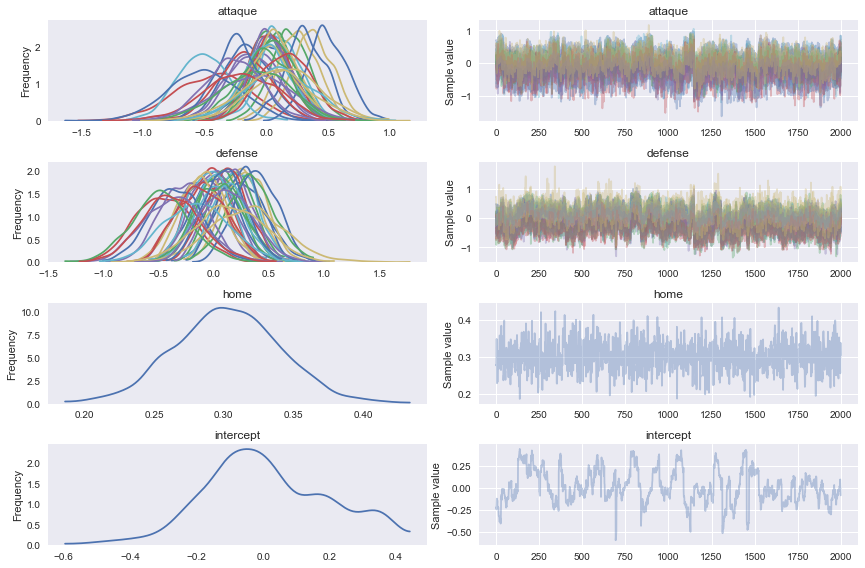

In [138]:
with model:
    trace = pm.sample(2000, n_init=100000)

    pm.traceplot(trace)

In [154]:
trace

<MultiTrace: 1 chains, 2000 iterations, 4 variables>

In [155]:
pm.diagnostics.gelman_rubin(trace)

ValueError: Gelman-Rubin diagnostic requires multiple chains of the same length.

In [148]:
pm.stats.df_summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
attaque__0,0.028347,0.190712,0.012529,-0.369984,0.383052
attaque__1,0.192674,0.161446,0.012268,-0.117464,0.518164
attaque__2,-0.441143,0.309081,0.012633,-1.073617,0.132207
attaque__3,-0.100802,0.195317,0.012245,-0.464721,0.284086
attaque__4,0.374365,0.161169,0.012282,0.041628,0.672775
attaque__5,0.115368,0.167540,0.012326,-0.202705,0.462592
attaque__6,-0.154794,0.189319,0.012390,-0.520043,0.215508
attaque__7,0.079175,0.173243,0.012233,-0.265693,0.415311
attaque__8,0.013243,0.167296,0.012304,-0.308706,0.355227
attaque__9,0.018762,0.168152,0.012444,-0.317435,0.339936


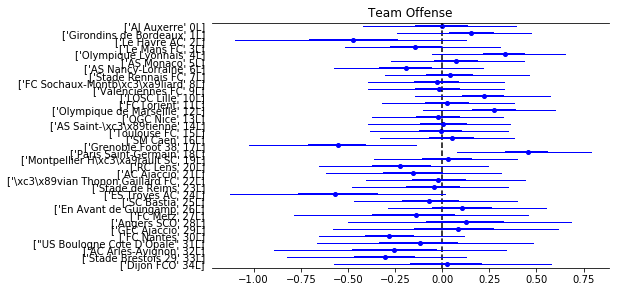

In [20]:
pm.forestplot(trace, varnames=['attaque'], ylabels=teams.values, main="Team Offense", chain_spacing=0.1)

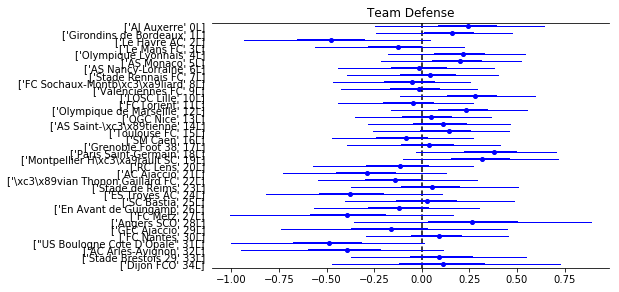

In [21]:
pm.forestplot(trace, varnames=['defense'], ylabels=teams.values, main="Team Defense", chain_spacing=0.1)

Les résultats sont cohérents, passons à la prédiction d'un nouveau match

# Prédiction de l'issue d'un match

On cherche à prédire l'issue d'un match. Pour cela, on change les paramètres d'entrée, et on relance notre modèle : (ici : PSG contre Grenoble (indice 18 vs indice 17), on s'attend à voir le PSG gagner..

In [22]:
model_input.set_value(np.array([[18],[17]]))
#model_output.set_value(np.array([[2],[0]]))

Et on sample depuis notre modèle avec les nouvelles entrées

In [23]:
ppc = pm.sample_ppc(trace[100:], model=model, samples=1000)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:12<00:00,  8.12it/s]


On fait un peu de mise en forme des résultats afin de pouvoir les exploiter simplement

In [24]:
away = pd.DataFrame(ppc['away_points'])
home = pd.DataFrame(ppc['home_points'])  

prediction_score = home.merge(away, how='inner', left_index=True, right_index=True)
prediction_score.columns = ['home_points', 'away_points']

In [25]:
prediction_score.head()

,home_points,away_points
0,4,0
1,1,2
2,1,0
3,3,2
4,2,0


In [26]:
def vainqueur(row):
    if row[0] > row[1]:
        return 'H'
    elif row[0] < row[1]:
        return 'A'
    else:
        return 'N'

prediction_score['vainqueur'] = prediction_score.apply(vainqueur, axis=1)

In [27]:
prediction_score.head()

,home_points,away_points,vainqueur
0,4,0,H
1,1,2,A
2,1,0,H
3,3,2,H
4,2,0,H


In [28]:
prediction_score.vainqueur.value_counts()

H    767
N    166
A     67
Name: vainqueur, dtype: int64

On calcule les probabilités associées

In [29]:
100 * prediction_score.vainqueur.value_counts() / prediction_score.vainqueur.count()

H    76.7
N    16.6
A     6.7
Name: vainqueur, dtype: float64

On va enfin calculer le résultat le plus probable (les buts encaissés pour chacune des équipes). Une rapide visualisation nous montre que le résultat le plus probable est 2-0. Vérifions le :

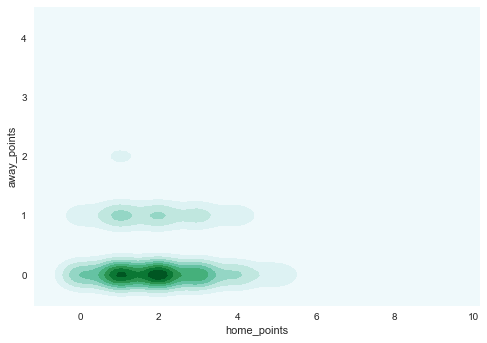

In [30]:
import seaborn
seaborn.kdeplot(data=prediction_score.home_points, data2=prediction_score.away_points, shade=True)

In [31]:
prediction_score.groupby(["home_points", "away_points"]).size()

home_points  away_points
0            0               81
             1               32
             2                6
             4                1
1            0              168
             1               69
             2               24
             3                2
             4                1
2            0              180
             1               64
             2               16
             3                1
3            0              119
             1               49
             2                9
4            0               62
             1               32
             2                3
             3                1
5            0               38
             1               10
             2                6
6            0               11
             1                5
             2                2
             3                1
7            0                5
             1                1
9            0                1
dtype: int64

In [32]:
prediction_score.groupby(["home_points", "away_points"]).size().idxmax()

(2, 0)

In [33]:
100. * prediction_score.groupby(["home_points", "away_points"]).size().max() / prediction_score.vainqueur.count()

18.0

Conclusion, le résultat est cohérent, on s'attend à ce que le PSG l'emporte (79% de chances) avec un score de 1-0 (21 % de chances)

# Evaluation des perfomances du modèle

Maintenant que l'on a vu que notre modèle est fonctionnel (et cohérent !), nous allons dans cette dernière section évaluer notre modèle. On commence par récupérer les données de cross-validation

In [34]:
observed_home_goals = match_ligue_1.home_team_goal.values[train_size+1:CV_size]
observed_away_goals = match_ligue_1.away_team_goal.values[train_size+1:CV_size]

home_team = match_ligue_1.i_home.values[train_size+1:CV_size]
away_team = match_ligue_1.i_away.values[train_size+1:CV_size]

Et on assigne ces nouveaux individus comme entrée et sortie de notre modèle

In [35]:
model_input.set_value(np.array([home_team,away_team], dtype=np.int32))
#model_output = theano.shared(np.array([observed_home_goals, observed_away_goals]))

Et on tire 100 réalisations pour chacun des matchs

In [36]:
ppc = pm.sample_ppc(trace[100:], model=model, samples=10000)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [30:19<00:00,  6.12it/s]


On va maintenant chercher à comparer nos prédictions avec la réalité :

In [37]:
away = pd.DataFrame(ppc['away_points'])
home = pd.DataFrame(ppc['home_points'])  

On crée un dataframe pour chaque match (chacun contenant 100 simulations par exemple)

In [38]:
prediction_score = [home[[i]].merge(away[[i]], how='inner', left_index=True, right_index=True) for i in range(len(home_team))]
for df in prediction_score:
    df.columns = ['home_points', 'away_points']

Pour chaque dataframe, on détermine l'équipe qui gagne

In [39]:
def vainqueur(row):
    if row[0] > row[1]:
        return 'H'
    elif row[0] < row[1]:
        return 'A'
    else:
        return 'N'

In [40]:
for df in prediction_score:
    df['vainqueur'] = df.apply(vainqueur, axis=1) 

On crée une liste de l'issue des matchs

In [97]:
resultats = list()
    
for df in prediction_score:
    home_score, away_score = df.groupby(["home_points", "away_points"]).size().idxmax()
    resultats.append(
        [df.vainqueur.value_counts().idxmax(), home_score, away_score]
    )
    
resultats = pd.DataFrame(np.array(resultats))
resultats.columns = ['prediction_vainqueur', 'prediction_home_score', 'prediction_away_score']

#on remet les scores au type int, sinon il sont converti en 'objet' ...
resultats[['prediction_home_score', 'prediction_away_score']] = resultats[['prediction_home_score', 'prediction_away_score']].astype(np.int32)

On met en forme aussi les vrais résultats

In [99]:
vrai_home = pd.DataFrame(observed_home_goals)
vrai_away = pd.DataFrame(observed_away_goals)  

In [100]:
vrai_resultats = vrai_home.merge(vrai_away, how='inner', left_index=True, right_index=True)
vrai_resultats.columns = ['home_points', 'away_points']

vrai_resultats['vainqueur'] = vrai_resultats.apply(vainqueur, axis=1)

vrai_resultats = vrai_resultats.merge(resultats, how='inner', left_index=True, right_index=True)

In [101]:
vrai_resultats

,home_points,away_points,vainqueur,prediction_vainqueur,prediction_home_score,prediction_away_score
0,1,2,A,H,1,0
1,2,2,N,H,1,0
2,3,0,H,H,1,0
3,2,2,N,H,1,0
4,1,2,A,H,1,0
5,0,2,A,H,1,0
6,2,1,H,H,1,0
7,1,1,N,H,1,0
8,1,0,H,H,1,0
9,1,2,A,A,1,1


On calcule notre score

In [102]:
np.sum(vrai_resultats.vainqueur.values == vrai_resultats.prediction_vainqueur.values) / float(len(home_team))

0.47775947281713343

In [103]:
from sklearn import metrics

In [104]:
metrics.confusion_matrix(vrai_resultats.vainqueur.values, vrai_resultats.prediction_vainqueur.values,labels=['A','H','N'])

array([[ 43, 124,   1],
       [ 26, 246,   0],
       [ 32, 134,   1]])

Confusion matrix, without normalization
[[ 43 124   1]
 [ 26 246   0]
 [ 32 134   1]]
Normalized confusion matrix
[[ 0.26  0.74  0.01]
 [ 0.1   0.9   0.  ]
 [ 0.19  0.8   0.01]]


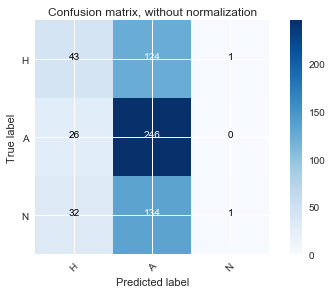

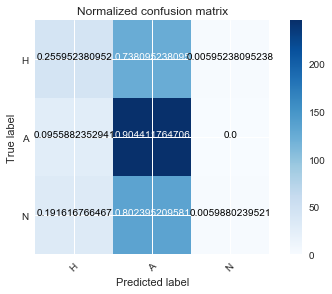

In [105]:
import itertools
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

class_names = ['H','A','N']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(vrai_resultats.vainqueur.values, vrai_resultats.prediction_vainqueur.values)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [106]:
metrics.accuracy_score(vrai_resultats.vainqueur.values, vrai_resultats.prediction_vainqueur.values)

0.47775947281713343

In [107]:
print(metrics.classification_report(vrai_resultats.vainqueur.values, vrai_resultats.prediction_vainqueur.values))

             precision    recall  f1-score   support

          A       0.43      0.26      0.32       168
          H       0.49      0.90      0.63       272
          N       0.50      0.01      0.01       167

avg / total       0.47      0.48      0.38       607



Commentaires :
- Les résultats sont encourageant pour un modèle aussi simple (quasiment 50% de réussite, à comparer aux 33% d'une méthode complètement aléatoire)
- On prédit trop souvent Away : peut être que le modèle favorise trop l'équipe à domicile...

In [108]:
vrai_resultats.vainqueur.value_counts() / vrai_resultats.vainqueur.count()

H    0.448105
A    0.276771
N    0.275124
Name: vainqueur, dtype: float64

prochaine étapes :
- améliorer le modèle hierarchique (prendre en compte les tirs cadrés, etc.)
- modéliser au niveau de chaque joueur ?
- écrire le code d'une simulation d'une saison entière pour obtenir le classement final

Enfin, on va compter le nombre de fois où notre projection de score est correcte

In [117]:
score_juste = vrai_resultats[vrai_resultats.home_points == vrai_resultats.prediction_home_score]
score_juste = score_juste[vrai_resultats.away_points == vrai_resultats.prediction_away_score]
len(score_juste) / float(len(vrai_resultats))

C:\Users\Alexis\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


0.12520593080724876

On a prédit le bon score dans 12,5% des cas.

In [118]:
score_juste

,home_points,away_points,vainqueur,prediction_vainqueur,prediction_home_score,prediction_away_score
8,1,0,H,H,1,0
15,1,0,H,H,1,0
17,1,1,N,H,1,1
30,1,1,N,H,1,1
39,1,0,H,H,1,0
41,1,0,H,H,1,0
51,1,0,H,H,1,0
54,1,0,H,H,1,0
83,0,0,N,H,0,0
88,2,0,H,H,2,0
